<a href="https://colab.research.google.com/github/vaishnavipathak/garbage-classification-cnn/blob/main/cnn_garbage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import os
import wandb
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


!pip install wandb gdown
!wandb login

!gdown '1cqAJ3b_TIEqHnKQGLGjxCBKS3MUatGa6'


DATA_DIR = "/content/garbage_data/"
!unzip -q Garbage_classification.zip -d {DATA_DIR}

print("Setup complete. Dataset downloaded and unzipped.")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!
^C
Downloading...
From (original): https://drive.google.com/uc?id=1cqAJ3b_TIEqHnKQGLGjxCBKS3MUatGa6
From (redirected): https://drive.google.com/uc?id=1cqAJ3b_TIEqHnKQGLGjxCBKS3MUatGa6&confirm=t&uuid=c810f0f3-2be3-4516-9c06-7d19d8b0c645
To: /content/Garbage_classification.zip
100% 43.0M/43.0M [00:01<00:00, 29.2MB/s]
Setup complete. Dataset downloaded and unzipped.


In [4]:
# Define Transformations
IMG_SIZE = 224
# We create two pipelines.
# The train transform randomly flips and rotates images for data augmentation.
# The val transform does not, ensuring we validate on unaltered images.
# Both pipelines resize, convert images to PyTorch Tensors, and normalize them.
#  we took Image size as 224*224 and batch size as 32.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# Load and Split the Dataset
dataset_folder = os.path.join(DATA_DIR, os.listdir(DATA_DIR)[0])
full_dataset = datasets.ImageFolder(dataset_folder)

val_split = 0.20
test_split = 0.20
train_size = int((1.0 - val_split - test_split) * len(full_dataset))
val_size = int(val_split * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

print(f"Splitting {len(full_dataset)} images into:")
print(f"- Training: {train_size} (60%)")
print(f"- Validation: {val_size} (20%)")
print(f"- Test: {test_size} (20%)")

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['val']

#Create DataLoaders
#  Data Loaders is powerful PyTorch tool that groups our dataset into batches and shuffles the training data each epoch to improve learning.
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Verify
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
images, labels = next(iter(train_loader))
print(f"\nBatch of images shape: {images.shape}")

Splitting 2527 images into:
- Training: 1516 (60%)
- Validation: 505 (20%)
- Test: 506 (20%)
Total images: 2527
Training images: 1516
Validation images: 505

Batch of images shape: torch.Size([32, 3, 224, 224])


class SimpleCNN defines our model as a Python class that inherits from PyTorch's base neural network module.

init is the constructor where we define all the layers our network will use.

I have grouped them into two nn.Sequential blocks: self.features for the convolutional part and self.classifier for the final dense layers.


In [5]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6, dense_neurons=256, dropout_rate=0.5):
        """
        Initializes the SimpleCNN model.

        Args:
            num_classes (int): The number of output classes (6 for our dataset).
            dense_neurons (int): The number of neurons in the hidden dense layer.
            dropout_rate (float): The dropout probability.
        """
        super(SimpleCNN, self).__init__()

        # 5 Conv-ReLU-MaxPool blocks as the "feature extractor".
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # defines the dense layer and output layer as the "classifier"
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32 * 7 * 7, out_features=dense_neurons),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=dense_neurons, out_features=num_classes)
        )

    def forward(self, x):
        """Defines how data flows through the network."""
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): L

In [6]:
import torch.optim as optim

device = torch.device("cuda")
print(f"Using device: {device}")

# instance of the model class we defined earlier
model = SimpleCNN()
# following command moves the model's parameters and computations onto the GPU.
model.to(device)

# Instantiate Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model, criterion, and optimizer are ready and configured for GPU.")

Using device: cuda
Model, criterion, and optimizer are ready and configured for GPU.


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=104):

    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        print(f"Starting Epoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the training data
        for inputs, labels in train_loader:
            # Move inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass, compute predicted outputs
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass, compute gradient of the loss
            loss.backward()

            #Step: update the weights
            optimizer.step()

            # Calculate running statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        # Disable gradient calculation for validation to save memory and computations.
        with torch.no_grad():
            # Iterate over the validation data
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}\n")

    print("Training Complete")
    return model

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=104)

Starting Epoch 1/102
Train Loss: 1.6756, Train Acc: 0.2751 | Val Loss: 1.5844, Val Acc: 0.3208

Starting Epoch 2/102
Train Loss: 1.4451, Train Acc: 0.4004 | Val Loss: 1.3978, Val Acc: 0.4693

Starting Epoch 3/102
Train Loss: 1.3287, Train Acc: 0.4367 | Val Loss: 1.3111, Val Acc: 0.4713

Starting Epoch 4/102
Train Loss: 1.2380, Train Acc: 0.4993 | Val Loss: 1.2818, Val Acc: 0.5149

Starting Epoch 5/102
Train Loss: 1.2117, Train Acc: 0.5152 | Val Loss: 1.3332, Val Acc: 0.5267

Starting Epoch 6/102
Train Loss: 1.1806, Train Acc: 0.5270 | Val Loss: 1.2730, Val Acc: 0.5228

Starting Epoch 7/102
Train Loss: 1.0767, Train Acc: 0.5877 | Val Loss: 1.2603, Val Acc: 0.5564

Starting Epoch 8/102
Train Loss: 1.0398, Train Acc: 0.6049 | Val Loss: 1.2345, Val Acc: 0.5703

Starting Epoch 9/102
Train Loss: 0.9741, Train Acc: 0.6398 | Val Loss: 1.1663, Val Acc: 0.5762

Starting Epoch 10/102


Training accuracy reached 76% and validation accuracy reached 71% in just 10 epochs. **Early Signs of Overfitting**

Now, **wandb**

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'optimizer': {
            'values': ['adam', 'sgd']
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'dense_neurons': {
            'values': [128, 256, 512]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.5]
        }
    }
}

In [ ]:
import wandb

def train():
    with wandb.init() as run:
        config = wandb.config

        # Create the model using hyperparameters from the sweep
        model = SimpleCNN(
            dense_neurons=config.dense_neurons,
            dropout_rate=config.dropout
        ).to(device)

        if config.optimizer == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        else:
            optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        # loss function
        criterion = nn.CrossEntropyLoss()

        # Training Loop (for 10 epochs)
        for epoch in range(10):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                train_loss = criterion(outputs, labels)
                train_loss.backward()
                optimizer.step()

            # Validation Loop
            model.eval()
            val_loss, val_corrects = 0.0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)

            # Log Metrics
            # Calculate and log the metrics that wandb will track
            avg_val_loss = val_loss / len(val_loader.dataset)
            val_accuracy = val_corrects.double() / len(val_loader.dataset)

            wandb.log({
                "epoch": epoch,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

In [ ]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="garbage-classification-sweep")

# Start the agent
# The agent will run the 'train' function 15 times with different hyperparameters.
wandb.agent(sweep_id, function=train, count=15)

Create sweep with ID: fjo4eviz
Sweep URL: https://wandb.ai/vaishnavipathak-iit-madras/garbage-classification-sweep/sweeps/fjo4eviz


wandb: Agent Starting Run: yh4ualxz with config:
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▃▄▅▅▅▆█▇
val_loss,██▆▆▄▃▄▂▁▁
epoch,9
val_accuracy,0.54257
val_loss,1.22949


wandb: Agent Starting Run: c90gknxc with config:
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▃▃▄▄▇▅█▇█
val_loss,██▇▆▄▃▄▃▃▁
epoch,9
val_accuracy,0.51089
val_loss,1.27627


wandb: Agent Starting Run: k0bpz50w with config:
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▂▄▆▆█▆▇██
val_loss,█▆▄▃▃▂▂▂▂▁
epoch,9
val_accuracy,0.60792
val_loss,1.10215


wandb: Agent Starting Run: u7gjutg1 with config:
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,9
val_accuracy,0.22376
val_loss,1.7757


wandb: Agent Starting Run: w5eqay2n with config:
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▄▅▇▇████
val_loss,██▆▄▄▃▂▁▁▁
epoch,9
val_accuracy,0.55248
val_loss,1.1733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z6n1rnaw with config:
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▄▃▅▆▆▆▇█
val_loss,██▇▇▅▄▄▅▂▁
epoch,9
val_accuracy,0.55446
val_loss,1.21036


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j5g6jzqp with config:
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁██▄██████
val_loss,▁▆▇▆▇█▇▆▅▆
epoch,9
val_accuracy,0.22376
val_loss,1.74156


wandb: Agent Starting Run: otmzqjkb with config:
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▄▄▄▆▆▇█▇█
val_loss,█▄▃▃▃▃▁▁▄▃
epoch,9
val_accuracy,0.57426
val_loss,1.26896


wandb: Agent Starting Run: 7u007qzp with config:
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄█▁▆▅▄▃▃▃
epoch,9
val_accuracy,0.22376
val_loss,1.74473


wandb: Agent Starting Run: 1f9u71vu with config:
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁█████████
val_loss,█▇▅▄▃▂▂▂▂▁
epoch,9
val_accuracy,0.22376
val_loss,1.71989


wandb: Agent Starting Run: 2ht2hr0r with config:
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▂▂▂▁
epoch,9
val_accuracy,0.22376
val_loss,1.71841


wandb: Agent Starting Run: a3ja821o with config:
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▄▅▅▇▇▆▅█
val_loss,██▆▅▄▂▃▅▄▁
epoch,9
val_accuracy,0.5703
val_loss,1.22146


wandb: Agent Starting Run: seo1ec0e with config:
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁█████████
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,9
val_accuracy,0.22376
val_loss,1.78055


wandb: Agent Starting Run: qz27f8sb with config:
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,9
val_accuracy,0.22376
val_loss,1.77881


wandb: Agent Starting Run: 8indqm3f with config:
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▇████████
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,9
val_accuracy,0.22376
val_loss,1.77897


The wandb sweep revealed that the learning rate was the most influential hyperparameter.
A lower learning rate was strongly correlated with higher validation accuracy.
The number of neurons in the dense layer had a minor positive effect, while the choice of optimizer and dropout rate were not significant factors.

In [ ]:
# The best hyperparameter configuration found from the wandb sweep
best_config = {
    'optimizer': 'adam',
    'learning_rate': 0.0001,
    'dense_neurons': 512,
    'dropout': 0.5
}

print("--- Building model with the best hyperparameters ---")
best_model = SimpleCNN(
    dense_neurons=best_config['dense_neurons'],
    dropout_rate=best_config['dropout']
).to(device)

criterion = nn.CrossEntropyLoss()
if best_config['optimizer'] == 'adam':
    optimizer = optim.Adam(best_model.parameters(), lr=best_config['learning_rate'])
else:
    optimizer = optim.SGD(best_model.parameters(), lr=best_config['learning_rate'], momentum=0.9)

print("\n--- Retraining the best model on the new 60% training split ---")
# Using the train_model function we defined earlier
best_model_trained = train_model(best_model, criterion, optimizer, train_loader, val_loader, num_epochs=10)


print("\n--- Evaluating on the Final Test Set ---")
best_model_trained.eval() # Set model to evaluation mode
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = best_model_trained(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f"\nFinal Test Accuracy with Best Model: {test_acc:.4f}")

--- Building model with the best hyperparameters ---

--- Retraining the best model on the new 60% training split ---
Starting Epoch 1/10
Train Loss: 1.7420, Train Acc: 0.2408 | Val Loss: 1.7265, Val Acc: 0.2238

Starting Epoch 2/10
Train Loss: 1.6773, Train Acc: 0.2533 | Val Loss: 1.6374, Val Acc: 0.2554

Starting Epoch 3/10
Train Loss: 1.5194, Train Acc: 0.3608 | Val Loss: 1.5115, Val Acc: 0.4020

Starting Epoch 4/10
Train Loss: 1.4038, Train Acc: 0.4354 | Val Loss: 1.4407, Val Acc: 0.4535

Starting Epoch 5/10
Train Loss: 1.3378, Train Acc: 0.4855 | Val Loss: 1.3864, Val Acc: 0.4535

Starting Epoch 6/10
Train Loss: 1.2727, Train Acc: 0.5106 | Val Loss: 1.3439, Val Acc: 0.4911

Starting Epoch 7/10
Train Loss: 1.2376, Train Acc: 0.5277 | Val Loss: 1.2922, Val Acc: 0.5248

Starting Epoch 8/10
Train Loss: 1.1920, Train Acc: 0.5567 | Val Loss: 1.2708, Val Acc: 0.5267

Starting Epoch 9/10
Train Loss: 1.1351, Train Acc: 0.5726 | Val Loss: 1.2577, Val Acc: 0.5287

Starting Epoch 10/10
Train 

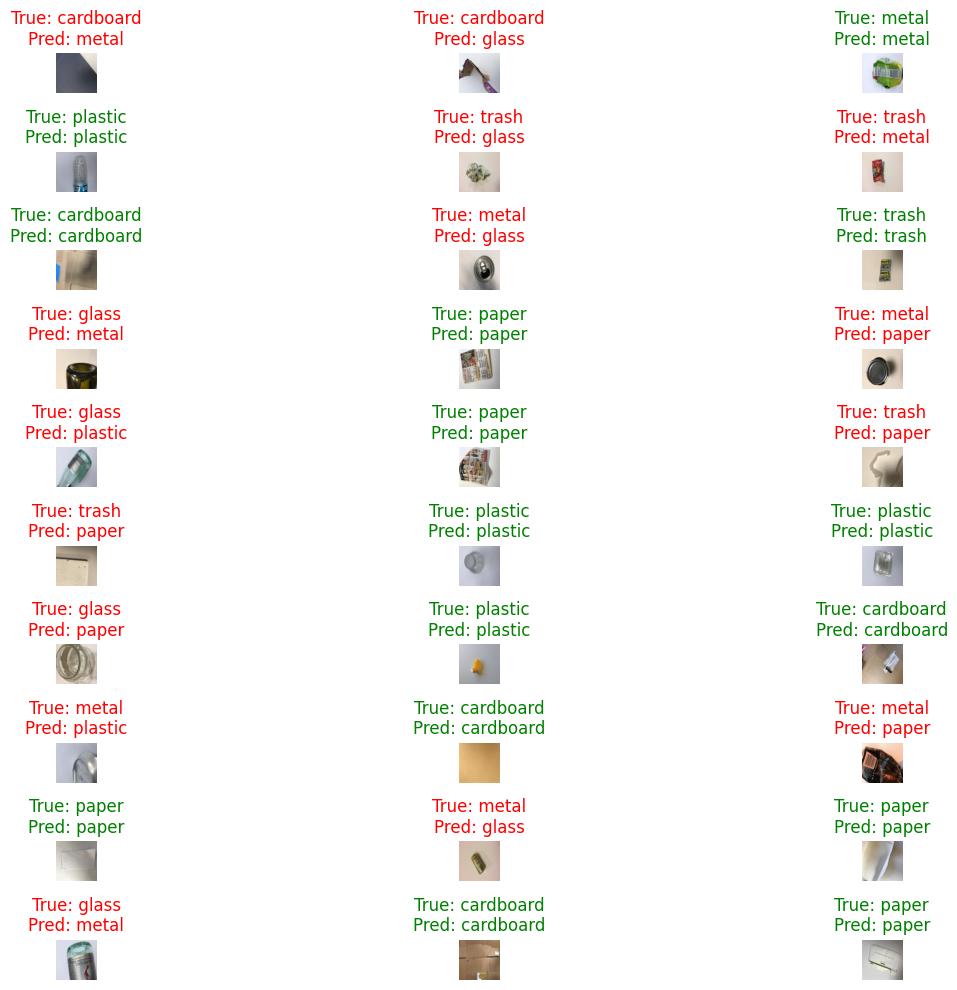

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=8)
    plt.axis('off')

# Get the class names from the dataset
class_names = full_dataset.classes

# Get a Batch of Test Data
inputs, classes = next(iter(test_loader))
# Move data to the same device as the model
inputs = inputs.to(device)

# Get Model Predictions
best_model_trained.eval()
with torch.no_grad():
    outputs = best_model_trained(inputs)
    _, preds = torch.max(outputs, 1)

# Create and Display the Grid
fig = plt.figure(figsize=(15, 10))
for i in range(30): # We'll display the first 30 images in the batch
    ax = fig.add_subplot(10, 3, i + 1, xticks=[], yticks=[])
    # The imshow function needs the image data on the CPU
    imshow(inputs[i].cpu())

    # Set the title color to green for correct predictions, red for incorrect
    title_color = "green" if class_names[preds[i]] == class_names[classes[i]] else "red"

    ax.set_title(f"True: {class_names[classes[i]]}\nPred: {class_names[preds[i]]}", color=title_color)

plt.tight_layout()
plt.show()